<a href="https://colab.research.google.com/github/panjiarlins/smart-security-camera-project/blob/main/ML%20Team/train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Download the dataset
!wget http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar

--2022-05-28 03:08:46--  http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar
Resolving host.robots.ox.ac.uk (host.robots.ox.ac.uk)... 129.67.94.152
Connecting to host.robots.ox.ac.uk (host.robots.ox.ac.uk)|129.67.94.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1999639040 (1.9G) [application/x-tar]
Saving to: ‘VOCtrainval_11-May-2012.tar’

VOCtrainval_11-May- 100%[===================>]   1.86G  36.2MB/s    in 54s     

2022-05-28 03:09:40 (35.2 MB/s) - ‘VOCtrainval_11-May-2012.tar’ saved [1999639040/1999639040]



In [ ]:
# Extract the dataset
!tar xvf VOCtrainval_11-May-2012.tar

In [3]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import copy
import cv2
from xml.etree import ElementTree
from google.colab import drive
%matplotlib inline

In [4]:
drive.mount(os.path.join(os.getcwd(), 'gdrive'))

Mounted at /content/gdrive


In [5]:
IMAGE_HEIGHT, IMAGE_WIDTH = 416, 416
LABELS = ['bicycle', 'bus', 'car', 'motorbike', 'person']
GRID_WIDTH, GRID_HEIGHT = 13, 13
BATCH_SIZE = 16
GROUNDTRUTH_BOX = 20
ANCHOR_BOXES = np.array([0.07095013, 0.13790466,
                         0.74620075, 0.8126473,
                         0.37125614, 0.65841728,
                         0.18252735, 0.41417845])
BOX = len(ANCHOR_BOXES) // 2

In [6]:
def get_annotation(images_path, annotation_path, labels=[], train_limit=None):
  '''Obtaining necessary object annotations in every xml files'''
  if not labels: assert False, 'Please input your labels!'

  images= []
  for annotation in sorted(os.listdir(annotation_path)):
    if 'xml' not in annotation: continue
    image = {'object': []}
    annotation_tree = ElementTree.parse(os.path.join(annotation_path, annotation))

    for element in annotation_tree.iter():
      if 'filename' in element.tag:
        image_path = os.path.join(images_path, element.text)
        if not os.path.exists(image_path):
            assert False, f'File {image_path} is not found!'
        image['filename'] = image_path

      if 'width' in element.tag:
        image['width'] = int(element.text)

      if 'height' in element.tag:
        image['height'] = int(element.text)

      if 'object' in element.tag:
        object = {}
        for attribute in list(element):
          if 'name' in attribute.tag:
            object['name'] = attribute.text
            if object['name'] not in labels: break
            else: image['object'] += [object]

          if 'bndbox' in attribute.tag:
            for dimension in list(attribute):
              for i in ['xmin', 'ymin', 'xmax', 'ymax']:
                if i in dimension.tag:
                  object[i] = int(round(float(dimension.text)))
                  break
    if not not image['object']:
      images += [image]

  if not (train_limit is None):
    train_limit = int(len(images) * train_limit)
    np.random.seed(42)
    np.random.shuffle(images)
    return images[:train_limit], images[train_limit:]
  
  return images

def get_total_labels(annotations):
  '''Calculate how many times a label gets iterated'''
  total_labels = {}
  for image in annotations:
    for object in image['object']:
      if object['name'] in total_labels:
        total_labels[object['name']] += 1
      else:
        total_labels[object['name']] = 1
  return total_labels

In [7]:
images_path = os.path.join('VOCdevkit', 'VOC2012', 'JPEGImages')
annotation_path = os.path.join('VOCdevkit', 'VOC2012', 'Annotations')

# Calling the function and storing all the obtained informations
# We set 60% for training and 40% for validation
train_images_dict, validation_images_dict = get_annotation(images_path, annotation_path, labels=LABELS, train_limit=0.8)

print(f'Number of train images = {len(train_images_dict)}')
print(f'Total of train labels = {get_total_labels(train_images_dict)}')

print(f'\nNumber of validation images = {len(validation_images_dict)}')
print(f'Total of validation labels = {get_total_labels(validation_images_dict)}')

Number of train images = 8696
Total of train labels = {'person': 13905, 'car': 2018, 'motorbike': 655, 'bicycle': 671, 'bus': 545}

Number of validation images = 2174
Total of validation labels = {'person': 3496, 'bicycle': 166, 'car': 474, 'bus': 140, 'motorbike': 146}


In [8]:
def get_objects_width_height(annotations):
  object_width_height = []
  for annotation in annotations:
    img_width, img_height = float(annotation['width']), float(annotation['height'])
    for object in annotation['object']:
      object_width = (object['xmax'] - object['xmin']) / img_width
      object_height = (object['ymax'] - object['ymin']) / img_height
      object_width_height.append([object_width, object_height])
  return np.array(object_width_height)

In [9]:
# TRAIN
train_objects_width_height = get_objects_width_height(train_images_dict)
print(f'Number of train objects = {train_objects_width_height.shape[0]}')
print(f'A sample train object with normalized [width, height] = {train_objects_width_height[0]}')

# VALIDATION
validation_objects_width_height = get_objects_width_height(validation_images_dict)
print(f'\nNumber of validation objects = {validation_objects_width_height.shape[0]}')
print(f'A sample validation object with normalized [width, height] = {validation_objects_width_height[0]}')

Number of train objects = 17794
A sample train object with normalized [width, height] = [0.99530516 0.794     ]

Number of validation objects = 4422
A sample validation object with normalized [width, height] = [0.06       0.14933333]


In [10]:
class ReadImage:
  def __init__(self, image_height, image_width):
    self.image_height = image_height
    self.image_width = image_width
  
  def fit(self, image_dict):
    if not isinstance(image_dict, dict): image_dict = {'filename': image_dict}
    
    image = cv2.imread(image_dict['filename'])
    if image is None: print(f'file {image_dict["filename"]} is not found!')
    image = cv2.resize(image, (self.image_height, self.image_width))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = image / 255.

    if 'object' in image_dict.keys():
      objects_dict = copy.deepcopy(image_dict['object'])

      for object_dict in objects_dict:
          for attribute in ['xmin', 'xmax', 'ymin', 'ymax']:
            if attribute in ['xmin', 'xmax']:
              object_dict[attribute] = int(object_dict[attribute] * float(self.image_width) / image.shape[1])
              object_dict[attribute] = max(0, min(object_dict[attribute], self.image_width))
            else:
              object_dict[attribute] = int(object_dict[attribute] * float(self.image_height) / image.shape[0])
              object_dict[attribute] = max(0, min(object_dict[attribute], self.image_height))
    else:
      return image
    return image, objects_dict

Before:


{'filename': 'VOCdevkit/VOC2012/JPEGImages/2011_003567.jpg',
 'height': 333,
 'object': [{'name': 'person',
   'xmax': 500,
   'xmin': 245,
   'ymax': 333,
   'ymin': 37}],
 'width': 500}


After:


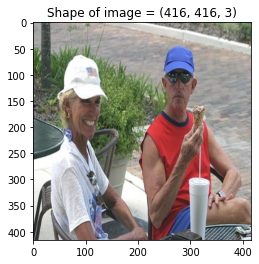

[{'name': 'person', 'xmax': 416, 'xmin': 245, 'ymax': 333, 'ymin': 37}]

In [11]:
# TRAIN
print('Before:')
display(train_images_dict[5])

print('\nAfter:')
readImage = ReadImage(IMAGE_HEIGHT, IMAGE_WIDTH)
image, objects_dict = readImage.fit(train_images_dict[5])
plt.imshow(image)
plt.title(f'Shape of image = {image.shape}')
plt.show()
display(objects_dict)

Before:


{'filename': 'VOCdevkit/VOC2012/JPEGImages/2009_003738.jpg',
 'height': 375,
 'object': [{'name': 'person', 'xmax': 273, 'xmin': 1, 'ymax': 375, 'ymin': 5},
  {'name': 'person', 'xmax': 500, 'xmin': 253, 'ymax': 364, 'ymin': 51}],
 'width': 500}


After:


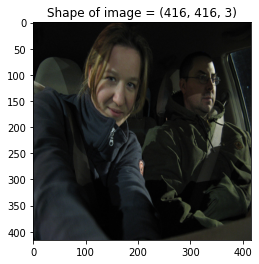

[{'name': 'person', 'xmax': 273, 'xmin': 1, 'ymax': 375, 'ymin': 5},
 {'name': 'person', 'xmax': 416, 'xmin': 253, 'ymax': 364, 'ymin': 51}]

In [12]:
# VALIDATION
print('Before:')
display(validation_images_dict[5])

print('\nAfter:')
readImage = ReadImage(IMAGE_HEIGHT, IMAGE_WIDTH)
image, objects_dict = readImage.fit(validation_images_dict[5])
plt.imshow(image)
plt.title(f'Shape of image = {image.shape}')
plt.show()
display(objects_dict)

In [13]:
class BoundingBox:
  def __init__(self, x_min, y_min, x_max, y_max, confidence=None, labels_probability=None):
    self.x_min, self.y_min, self.x_max, self.y_max = x_min, y_min, x_max, y_max
    self.confidence = confidence
    self.set_label(labels_probability)
  
  def set_label(self, labels_probability):
    self.labels_probability = labels_probability
    self.label = np.argmax(self.labels_probability)
  
  def get_label(self):
    return self.label
  
  def get_highest_label_probability_score(self):
    return self.labels_probability[self.label]

class AnchorBoxMatching:
  def __init__(self, anchors=None):
    if not (anchors is None):
      self.anchors = [BoundingBox(0, 0, anchors[i], anchors[i + 1]) for i in range(0, len(anchors), 2)]
  
  def _calculate_intersection(self, box1, box2):
    x1_box1, x2_box1 = box1
    x1_box2, x2_box2 = box2

    if x1_box2 < x1_box1:
      if x2_box2 < x1_box1: return 0
      else: return min(x2_box1, x2_box2) - x1_box1
    else:
      if x2_box1 < x1_box2: return 0
      else: return min(x2_box1, x2_box2) - x1_box2
  
  def _calculate_box_area(self, box):
    box_width = box.x_max - box.x_min
    box_height = box.y_max - box.y_min
    return box_width * box_height
  
  def calculate_iou(self, box1, box2):
    intersection_width = self._calculate_intersection([box1.x_min, box1.x_max], [box2.x_min, box2.x_max])
    intersection_height = self._calculate_intersection([box1.y_min, box1.y_max], [box2.y_min, box2.y_max])
    intersection_area = intersection_width * intersection_height

    box1_area = self._calculate_box_area(box1)
    box2_area = self._calculate_box_area(box2)
    union_area = box1_area + box2_area - intersection_area

    return float(intersection_area) / union_area
  
  def fit(self, box_width, box_height):
    matched_anchor, max_iou = -1, -1

    for anchor_index in range(len(self.anchors)):
      iou = self.calculate_iou(BoundingBox(0, 0, box_width, box_height), self.anchors[anchor_index])
      if max_iou < iou: matched_anchor, max_iou = anchor_index, iou

    return matched_anchor, max_iou

In [14]:
# TEST
print('Anchor boxes:')
index = 0
for i in range(0, len(ANCHOR_BOXES), 2):
  print(f'\tindex={index}  width={ANCHOR_BOXES[i]}  height={ANCHOR_BOXES[i + 1]}')
  index += 1

print('\nTest class AnchorBoxMatching():')
anchor_box_matching = AnchorBoxMatching(ANCHOR_BOXES)
box_test_width, box_test_height = 0.2, 0.6
box_test_matched_anchor, box_test_iou = anchor_box_matching.fit(box_test_width, box_test_height)
print(f'\tBox: width={box_test_width} height={box_test_height}')
print(f'\tMatched AnchorBox: index={box_test_matched_anchor} iou={box_test_iou}')

Anchor boxes:
	index=0  width=0.07095013  height=0.13790466
	index=1  width=0.74620075  height=0.8126473
	index=2  width=0.37125614  height=0.65841728
	index=3  width=0.18252735  height=0.41417845

Test class AnchorBoxMatching():
	Box: width=0.2 height=0.6
	Matched AnchorBox: index=3 iou=0.6299907908800624


In [15]:
def centerxy_gridcellscale_rescaler(object_configuration, image_configuration):
  centerx = (object_configuration['xmin'] + object_configuration['xmax']) / 2.
  centery = (object_configuration['ymin'] + object_configuration['ymax']) / 2.

  rescaled_centerx = (centerx / image_configuration['IMAGE_WIDTH']) * image_configuration['GRID_WIDTH']
  rescaled_centery = (centery / image_configuration['IMAGE_HEIGHT']) * image_configuration['GRID_HEIGHT']

  return rescaled_centerx, rescaled_centery

def widthheight_gridcellscale_rescaler(object_configuration, image_configuration):
  width = float(object_configuration['xmax'] - object_configuration['xmin'])
  height = float(object_configuration['ymax'] - object_configuration['ymin'])
  
  rescaled_width = (width / image_configuration['IMAGE_WIDTH']) * image_configuration['GRID_WIDTH']
  rescaled_height = (height / image_configuration['IMAGE_HEIGHT']) * image_configuration['GRID_HEIGHT']

  return rescaled_width, rescaled_height

In [16]:
# TEST
print('Test for centerxy_gridcellscale_rescaler() and widthheight_gridcellscale_rescaler():')
test_image_configuration = {'IMAGE_WIDTH': 416, 'IMAGE_HEIGHT': 416, 'GRID_WIDTH': 13, 'GRID_HEIGHT': 13}
test_object_configuration = {'xmin': 100, 'ymin': 50, 'xmax': 400, 'ymax': 300}

print('Before:')
display(test_image_configuration)
display(test_object_configuration)

test_centerx, test_centery = centerxy_gridcellscale_rescaler(test_object_configuration, test_image_configuration)
test_width, test_height = widthheight_gridcellscale_rescaler(test_object_configuration, test_image_configuration)

print('\nAfter:')
print(f'rescaled centerx={test_centerx}\t\tin range 0-{test_image_configuration["GRID_WIDTH"]}')
print(f'rescaled centery={test_centery}\t\tin range 0-{test_image_configuration["GRID_HEIGHT"]}')
print(f'rescaled width={test_width}\t\tin range 0-{test_image_configuration["GRID_WIDTH"]}')
print(f'rescaled height={test_height}\t\tin range 0-{test_image_configuration["GRID_HEIGHT"]}')

Test for centerxy_gridcellscale_rescaler() and widthheight_gridcellscale_rescaler():
Before:


{'GRID_HEIGHT': 13, 'GRID_WIDTH': 13, 'IMAGE_HEIGHT': 416, 'IMAGE_WIDTH': 416}

{'xmax': 400, 'xmin': 100, 'ymax': 300, 'ymin': 50}


After:
rescaled centerx=7.8125		in range 0-13
rescaled centery=5.46875		in range 0-13
rescaled width=9.375		in range 0-13
rescaled height=7.8125		in range 0-13


In [17]:
class BatchGenerator(tf.keras.utils.Sequence):
  def __init__(self, images, image_configuration, shuffle=True):
    self.images_dict = images
    self.shuffle = shuffle
    if self.shuffle: np.random.shuffle(self.images_dict)

    self.image_configuration = image_configuration
    self.anchorBoxMatching = AnchorBoxMatching(self.image_configuration['ANCHORS'])
    self.readImage = ReadImage(self.image_configuration['IMAGE_HEIGHT'], self.image_configuration['IMAGE_WIDTH'])
  
  def __getitem__(self, batch_index):
    input_images_batch = np.zeros((self.image_configuration['BATCH_SIZE'],
                                   self.image_configuration['IMAGE_HEIGHT'],
                                   self.image_configuration['IMAGE_WIDTH'],
                                   3
                                   ))
    input_boxes_batch = np.zeros((self.image_configuration['BATCH_SIZE'],
                                  1,
                                  1,
                                  1,
                                  self.image_configuration['GROUNDTRUTH_BOX'],
                                  4
                                  ))
    output_batch = np.zeros((self.image_configuration['BATCH_SIZE'],
                             self.image_configuration['GRID_HEIGHT'],
                             self.image_configuration['GRID_WIDTH'],
                             self.image_configuration['BOX'],
                             4 + 1 + len(self.image_configuration['LABELS'])
                             ))
    
    leftmost_image_in_batch = batch_index * self.image_configuration['BATCH_SIZE']
    rightmost_image_in_batch = (batch_index + 1) * self.image_configuration['BATCH_SIZE']

    if rightmost_image_in_batch > len(self.images_dict):
      rightmost_image_in_batch = len(self.images_dict)
      leftmost_image_in_batch = rightmost_image_in_batch - self.image_configuration['BATCH_SIZE']

    image_index = 0
    for train_instance in self.images_dict[leftmost_image_in_batch : rightmost_image_in_batch]:
        image, objects_dict = self.readImage.fit(train_instance)

        groundtruth_box_index = 0
        for object_dict in objects_dict:
          if object_dict['xmax'] > object_dict['xmin'] and object_dict['ymax'] > object_dict['ymin'] and object_dict['name'] in self.image_configuration['LABELS']:
            centerx, centery = centerxy_gridcellscale_rescaler(object_dict, self.image_configuration)
            
            centerx_grid, centery_grid = int(np.floor(centerx)), int(np.floor(centery))

            if centerx_grid < self.image_configuration['GRID_WIDTH'] and centery_grid < self.image_configuration['GRID_HEIGHT']:
              label_index = self.image_configuration['LABELS'].index(object_dict['name'])
              width, height = widthheight_gridcellscale_rescaler(object_dict, self.image_configuration)
              fitted_anchor, _ = self.anchorBoxMatching.fit(width, height)

              output_batch[image_index, centery_grid, centerx_grid, fitted_anchor, 0:4] = [centerx, centery, width, height]
              output_batch[image_index, centery_grid, centerx_grid, fitted_anchor, 4  ] = 1.
              output_batch[image_index, centery_grid, centerx_grid, fitted_anchor, 5:] = 0
              output_batch[image_index, centery_grid, centerx_grid, fitted_anchor, 5 + label_index] = 1

              input_boxes_batch[image_index, 0, 0, 0, groundtruth_box_index] = [centerx, centery, width, height]

              groundtruth_box_index += 1
              groundtruth_box_index = groundtruth_box_index % int(self.image_configuration['GROUNDTRUTH_BOX'])

        input_images_batch[image_index] = image
        image_index += 1
    return [input_images_batch, input_boxes_batch], output_batch
  
  def __len__(self):
    return int(np.ceil(len(self.images_dict) / float(self.image_configuration['BATCH_SIZE'])))
  
  def on_epoch_end(self):
    if self.shuffle: np.random.shuffle(self.images_dict)

In [18]:
# Rescale AnchorBox into grid cell scale

# TRAIN
ANCHORS = copy.deepcopy(ANCHOR_BOXES)
ANCHORS[::2], ANCHORS[1::2] = ANCHORS[::2] * GRID_WIDTH, ANCHORS[1::2] * GRID_HEIGHT

In [19]:
image_configuration = {'LABELS' : LABELS,
                       'ANCHORS' : ANCHORS,
                       'IMAGE_HEIGHT' : IMAGE_HEIGHT,
                       'IMAGE_WIDTH' : IMAGE_WIDTH,
                       'GRID_HEIGHT' : GRID_HEIGHT,
                       'GRID_WIDTH' : GRID_WIDTH,
                       'BOX' : BOX,
                       'BATCH_SIZE' : BATCH_SIZE,
                       'GROUNDTRUTH_BOX' : GROUNDTRUTH_BOX
                       }

# TRAIN
train_batch_generator = BatchGenerator(train_images_dict, image_configuration)

# VALIDATION
validation_batch_generator = BatchGenerator(validation_images_dict, image_configuration, shuffle=False)

print('Get a sample batch item:\n')
[test_input_images_batch, test_input_boxes_batch], test_output_batch = train_batch_generator.__getitem__(batch_index=0)
print(f'input_images_batch.shape\t= {test_input_images_batch.shape}\t= (BATCH_SIZE, IMAGE_HEIGHT, IMAGE_WIDTH, COLOR)')
print(f'input_boxes_batch.shape\t\t= {test_input_boxes_batch.shape}\t= (BATCH_SIZE, 1, 1, 1, GROUNDTRUTH_BOX, [centerx, centery, width, height])')
print(f'output_batch.shape\t\t= {test_output_batch.shape}\t= (BATCH_SIZE, GRID_HEIGHT, GRID_WIDTH, fitted ANCHORBOX, [centerx, centery, width, height] + confidence + N labels index)')


Get a sample batch item:

input_images_batch.shape	= (16, 416, 416, 3)	= (BATCH_SIZE, IMAGE_HEIGHT, IMAGE_WIDTH, COLOR)
input_boxes_batch.shape		= (16, 1, 1, 1, 20, 4)	= (BATCH_SIZE, 1, 1, 1, GROUNDTRUTH_BOX, [centerx, centery, width, height])
output_batch.shape		= (16, 13, 13, 4, 10)	= (BATCH_SIZE, GRID_HEIGHT, GRID_WIDTH, fitted ANCHORBOX, [centerx, centery, width, height] + confidence + N labels index)


In [20]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Reshape, Activation, Conv2D, Input, MaxPooling2D, BatchNormalization, Lambda, LeakyReLU, concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

input_images = Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
input_boxes = Input(shape=(1, 1, 1, GROUNDTRUTH_BOX, 4))

# Layer 1
x = Conv2D(32, kernel_size=(3,3), padding='same', name='conv2d_1', use_bias=False)(input_images)
x = BatchNormalization(name='batchnormalization_1')(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 2
x = Conv2D(64, kernel_size=(3,3), padding='same', name='conv2d_2', use_bias=False)(x)
x = BatchNormalization(name='batchnormalization_2')(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 3
x = Conv2D(128, kernel_size=(3,3), padding='same', name='conv2d_3', use_bias=False)(x)
x = BatchNormalization(name='batchnormalization_3')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 4
x = Conv2D(64, kernel_size=(1,1), padding='same', name='conv2d_4', use_bias=False)(x)
x = BatchNormalization(name='batchnormalization_4')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 5
x = Conv2D(128, kernel_size=(3,3), padding='same', name='conv2d_5', use_bias=False)(x)
x = BatchNormalization(name='batchnormalization_5')(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 6
x = Conv2D(256, kernel_size=(3,3), padding='same', name='conv2d_6', use_bias=False)(x)
x = BatchNormalization(name='batchnormalization_6')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 7
x = Conv2D(128, kernel_size=(1,1), padding='same', name='conv2d_7', use_bias=False)(x)
x = BatchNormalization(name='batchnormalization_7')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 8
x = Conv2D(256, kernel_size=(3,3), padding='same', name='conv2d_8', use_bias=False)(x)
x = BatchNormalization(name='batchnormalization_8')(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 9
x = Conv2D(512, kernel_size=(3,3), padding='same', name='conv2d_9', use_bias=False)(x)
x = BatchNormalization(name='batchnormalization_9')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 10
x = Conv2D(256, kernel_size=(1,1), padding='same', name='conv2d_10', use_bias=False)(x)
x = BatchNormalization(name='batchnormalization_10')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 11
x = Conv2D(512, kernel_size=(3,3), padding='same', name='conv2d_11', use_bias=False)(x)
x = BatchNormalization(name='batchnormalization_11')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 12
x = Conv2D(256, kernel_size=(1,1), padding='same', name='conv2d_12', use_bias=False)(x)
x = BatchNormalization(name='batchnormalization_12')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 13
x = Conv2D(512, kernel_size=(3,3), padding='same', name='conv2d_13', use_bias=False)(x)
x = BatchNormalization(name='batchnormalization_13')(x)
x = LeakyReLU(alpha=0.1)(x)

skip_connection = x

x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 14
x = Conv2D(1024, kernel_size=(3,3), padding='same', name='conv2d_14', use_bias=False)(x)
x = BatchNormalization(name='batchnormalization_14')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 15
x = Conv2D(512, kernel_size=(1,1), padding='same', name='conv2d_15', use_bias=False)(x)
x = BatchNormalization(name='batchnormalization_15')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 16
x = Conv2D(1024, kernel_size=(3,3), padding='same', name='conv2d_16', use_bias=False)(x)
x = BatchNormalization(name='batchnormalization_16')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 17
x = Conv2D(512, kernel_size=(1,1), padding='same', name='conv2d_17', use_bias=False)(x)
x = BatchNormalization(name='batchnormalization_17')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 18
x = Conv2D(1024, kernel_size=(3,3), padding='same', name='conv2d_18', use_bias=False)(x)
x = BatchNormalization(name='batchnormalization_18')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 19
x = Conv2D(1024, kernel_size=(3,3), padding='same', name='conv2d_19', use_bias=False)(x)
x = BatchNormalization(name='batchnormalization_19')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 20
x = Conv2D(1024, kernel_size=(3,3), padding='same', name='conv2d_20', use_bias=False)(x)
x = BatchNormalization(name='batchnormalization_20')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 21
skip_connection = Conv2D(64, kernel_size=(1,1), padding='same', name='conv2d_21', use_bias=False)(skip_connection)
skip_connection = BatchNormalization(name='batchnormalization_21')(skip_connection)
skip_connection = LeakyReLU(alpha=0.1)(skip_connection)
skip_connection = Lambda(lambda x: tf.nn.space_to_depth(x, block_size=2))(skip_connection)

x = concatenate([skip_connection, x])

# Layer 22
x = Conv2D(1024, kernel_size=(3,3), padding='same', name='conv2d_22', use_bias=False)(x)
x = BatchNormalization(name='batchnormalization_22')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 23
x = Conv2D(512, kernel_size=(3,3), padding='same', name='conv2d_23')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 24
x = Conv2D(1024, kernel_size=(3,3), padding='same', name='conv2d_24')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 25
x = Conv2D(BOX * (4 + 1 + len(LABELS)), kernel_size=(1,1), padding='same', name='conv2d_25')(x)

output = Reshape((GRID_HEIGHT, GRID_WIDTH, BOX, 4 + 1 + len(LABELS)))(x)
output = Lambda(lambda args: args[0])([output, input_boxes])

model = Model([input_images, input_boxes], output)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 416, 416, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 416, 416, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batchnormalization_1 (BatchNor  (None, 416, 416, 32  128        ['conv2d_1[0][0]']               
 malization)                    )                                                             

In [21]:
!wget https://pjreddie.com/media/files/yolov2.weights

--2022-05-28 03:10:33--  https://pjreddie.com/media/files/yolov2.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 203934260 (194M) [application/octet-stream]
Saving to: ‘yolov2.weights’

yolov2.weights      100%[===================>] 194.49M  21.3MB/s    in 7.4s    

2022-05-28 03:10:41 (26.3 MB/s) - ‘yolov2.weights’ saved [203934260/203934260]



In [22]:
class ReadWeight:
  def __init__(self, weight_path):
    self.weights = np.fromfile(weight_path, dtype=np.float32)
    self.offset = 4
      
  def get_bytes(self, weight_length):
    self.offset += weight_length
    return self.weights[self.offset - weight_length : self.offset]

  def reset(self):
    self.offset = 4

In [23]:
# Read pretrained weight from file
pretrained_weight_path = os.path.join(os.getcwd(), 'yolov2.weights')
readWeight = ReadWeight(pretrained_weight_path)
print(f'Pretrained weights.shape = {readWeight.weights.shape}')

Pretrained weights.shape = (50983565,)


In [24]:
readWeight.reset()
total_conv2d_layer = 22

for i in range(1, total_conv2d_layer + 1):
  conv2d_layer = model.get_layer(f'conv2d_{i}')

  if i < total_conv2d_layer:
    batchnormalization_layer = model.get_layer(f'batchnormalization_{i}')
    weight_length = np.prod(batchnormalization_layer.get_weights()[0].shape)

    beta = readWeight.get_bytes(weight_length)
    gamma = readWeight.get_bytes(weight_length)
    mean_moving_average = readWeight.get_bytes(weight_length)
    variance_moving_average = readWeight.get_bytes(weight_length)

    batchnormalization_layer.set_weights([gamma, beta, mean_moving_average, variance_moving_average])

  bias = readWeight.get_bytes(np.prod(conv2d_layer.get_weights()[1].shape)) if len(conv2d_layer.get_weights()) > 1 else None
  kernel = readWeight.get_bytes(np.prod(conv2d_layer.get_weights()[0].shape))
  kernel = kernel.reshape(list(reversed(conv2d_layer.get_weights()[0].shape)))
  kernel = kernel.transpose((2, 3, 1, 0))

  if bias is None: conv2d_layer.set_weights([kernel])
  else: conv2d_layer.set_weights([kernel, bias])

In [25]:
for i in range(23, 26):
  kernel = np.random.normal(size=model.get_layer(f'conv2d_{i}').get_weights()[0].shape) / (GRID_HEIGHT * GRID_WIDTH)
  bias = np.random.normal(size=model.get_layer(f'conv2d_{i}').get_weights()[1].shape) / (GRID_HEIGHT * GRID_WIDTH)
  model.get_layer(f'conv2d_{i}').set_weights([kernel, bias])

In [26]:
LAMBDA_NO_OBJECT = 0.5
LAMBDA_OBJECT    = 2.5
LAMBDA_COORD     = 0.5
LAMBDA_CLASS     = 0.5

In [27]:
def prediction_gridcellscale_scaler(output_prediction, BATCH_SIZE, GRID_WIDTH, GRID_HEIGHT, ANCHORS):
  total_anchor = len(ANCHORS) // 2

  # Create grid cell
  grid_height_cell = tf.reshape(tf.tile(tf.range(GRID_WIDTH, dtype=tf.float32), multiples=[GRID_HEIGHT]), shape=(1, GRID_HEIGHT, GRID_WIDTH, 1, 1))
  grid_width_cell = tf.transpose(grid_height_cell, perm=(0,2,1,3,4))
  grid_cell = tf.tile(tf.concat([grid_height_cell, grid_width_cell], axis=-1), multiples=[BATCH_SIZE, 1, 1, total_anchor, 1])
  
  # Rescale centerxy and widthheight prediction into gridcellscale
  centerxy_prediction = tf.sigmoid(output_prediction[..., :2]) + grid_cell
  widthheight_prediction = tf.exp(output_prediction[..., 2:4]) * np.reshape(ANCHORS, [1, 1, 1, total_anchor, 2])

  confidence_prediction = tf.sigmoid(output_prediction[..., 4])
  label_prediction = output_prediction[..., 5:]

  return centerxy_prediction, widthheight_prediction, confidence_prediction, label_prediction

In [28]:
def get_groundtruth(output_groundtruth):
  centerxy_groundtruth = output_groundtruth[..., 0:2]
  widthheight_groundtruth = output_groundtruth[..., 2:4]
  confidence_groundtruth = output_groundtruth[...,4]
  label_groundtruth = tf.argmax(output_groundtruth[..., 5:], -1)

  return centerxy_groundtruth, widthheight_groundtruth, confidence_groundtruth, label_groundtruth

In [29]:
def calculate_loss_centerxywidthheight(LAMBDA_COORD, confidence_groundtruth, centerxy_groundtruth, centerxy_prediction, widthheight_groundtruth, widthheight_prediction):
  L_obj = tf.expand_dims(tf.cast(confidence_groundtruth, dtype=tf.float32), axis=-1)
  N_L_obj = tf.reduce_sum(tf.cast(L_obj > 0.0, dtype=tf.float32))

  loss_centerxy = tf.reduce_sum(tf.square(centerxy_groundtruth - centerxy_prediction) * L_obj)
  loss_widthheight = tf.reduce_sum(tf.square(widthheight_groundtruth - widthheight_prediction) * L_obj)

  loss_centerxywidthheight = (LAMBDA_COORD / N_L_obj) * (loss_centerxy + loss_widthheight)

  return loss_centerxywidthheight

In [30]:
def calculate_loss_label(LAMBDA_CLASS, confidence_groundtruth, label_groundtruth, label_prediction):  
  L_obj = confidence_groundtruth
  N_L_obj = tf.reduce_sum(tf.cast(L_obj > 0.0, tf.float32))
  loss_label = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=label_groundtruth, logits=label_prediction)
  loss_label = tf.reduce_sum(loss_label * L_obj)
  loss_label = (LAMBDA_CLASS / N_L_obj) * loss_label
  
  return loss_label

In [31]:
def get_existed_object_iou(confidence_groundtruth,
                           centerxy_groundtruth, widthheight_groundtruth,
                           centerxy_prediction, widthheight_prediction):
  
  max_xy_groundtruth = centerxy_groundtruth + (widthheight_groundtruth * .5)
  min_xy_groundtruth = centerxy_groundtruth - (widthheight_groundtruth * .5)

  max_xy_prediction = centerxy_prediction + (widthheight_prediction * .5)
  min_xy_prediction = centerxy_prediction - (widthheight_prediction * .5)

  min_xy_intersection = tf.maximum(min_xy_prediction, min_xy_groundtruth)
  max_xy_intersection = tf.minimum(max_xy_prediction, max_xy_groundtruth)
  widthheight_intersection = tf.maximum(max_xy_intersection - min_xy_intersection, 0.)
  intersection_area = widthheight_intersection[..., 0] * widthheight_intersection[..., 1]

  groundtruth_area = widthheight_groundtruth[..., 0] * widthheight_groundtruth[..., 1]
  prediction_area = widthheight_prediction[..., 0] * widthheight_prediction[..., 1]
  union_area = prediction_area + groundtruth_area - intersection_area

  return (intersection_area / union_area) * confidence_groundtruth

In [32]:
def calculate_loss_confidence(LAMBDA_OBJECT, LAMBDA_NO_OBJECT, existed_object_iou, confidence_groundtruth, confidence_prediction):
  L_noobj = tf.cast(existed_object_iou < .6, tf.float32) * (1 - confidence_groundtruth)
  L_obj = confidence_groundtruth
  IOU = existed_object_iou
  N_conf = tf.reduce_sum(L_obj + L_noobj)

  loss_confidence = LAMBDA_OBJECT * L_obj * tf.square(IOU - confidence_prediction)
  loss_confidence = loss_confidence + (LAMBDA_NO_OBJECT * L_noobj * tf.square(IOU - confidence_prediction))
  loss_confidence = tf.reduce_sum(loss_confidence) / N_conf

  return loss_confidence

In [33]:
def custom_loss(output_batch, output_prediction):
  # Rescale prediction output into grid cell scale
  (centerxy_prediction, widthheight_prediction,
  confidence_prediction, label_prediction) = prediction_gridcellscale_scaler(output_prediction, BATCH_SIZE,
                                                                            GRID_WIDTH, GRID_HEIGHT, ANCHORS)
  
  # Parse ground truth output
  (centerxy_groundtruth, widthheight_groundtruth,
  confidence_groundtruth, label_groundtruth) = get_groundtruth(output_batch)

  # Calculate centerx, centery, width, height loss
  loss_centerxywidthheight = calculate_loss_centerxywidthheight(LAMBDA_COORD, confidence_groundtruth,
                                                                centerxy_groundtruth, centerxy_prediction,
                                                                widthheight_groundtruth, widthheight_prediction)
  
  # Calculate label probability loss
  loss_label = calculate_loss_label(LAMBDA_CLASS, confidence_groundtruth, label_groundtruth, label_prediction)

  # Calculate IoU between groundtruth and prediction box
  existed_object_iou = get_existed_object_iou(confidence_groundtruth,
                                              centerxy_groundtruth, widthheight_groundtruth,
                                              centerxy_prediction, widthheight_prediction)
  
  # Calculate confidence loss
  loss_confidence = calculate_loss_confidence(LAMBDA_OBJECT, LAMBDA_NO_OBJECT, existed_object_iou,
                                              confidence_groundtruth, confidence_prediction)
  
  return loss_centerxywidthheight + loss_label + loss_confidence

In [34]:
early_stopping = EarlyStopping(monitor='loss', min_delta=1e-3, patience=4, verbose=1, mode='min')
model_checkpoint = ModelCheckpoint(filepath=os.path.join(os.getcwd(), 'gdrive', 'My Drive', 'capstone_project', f'model-groundtruthbox{GROUNDTRUTH_BOX}-anchorboxes{ANCHOR_BOXES.tolist()}.h5'),
                                   monitor='loss',
                                   verbose=1,
                                   save_best_only=True,
                                   mode='min'
                                   )

model.compile(loss=custom_loss, optimizer=Adam(learning_rate=5e-5))

In [ ]:
model.fit(train_batch_generator,
          steps_per_epoch=len(train_batch_generator),
          epochs=50,
          callbacks=[early_stopping, model_checkpoint],
          verbose=1,
          validation_data=validation_batch_generator,
          validation_steps=len(validation_batch_generator)
          )

Epoch 1/50
544/544 [==============================] - ETA: 0s - loss: 1.3286
Epoch 1: loss improved from inf to 1.32857, saving model to /content/gdrive/My Drive/capstone_project/model-groundtruthbox20-anchorboxes[0.07095013, 0.13790466, 0.74620075, 0.8126473, 0.37125614, 0.65841728, 0.18252735, 0.41417845].h5
544/544 [==============================] - 237s 400ms/step - loss: 1.3286 - val_loss: 0.8863
Epoch 2/50
544/544 [==============================] - ETA: 0s - loss: 0.6989
Epoch 2: loss improved from 1.32857 to 0.69891, saving model to /content/gdrive/My Drive/capstone_project/model-groundtruthbox20-anchorboxes[0.07095013, 0.13790466, 0.74620075, 0.8126473, 0.37125614, 0.65841728, 0.18252735, 0.41417845].h5
544/544 [==============================] - 231s 424ms/step - loss: 0.6989 - val_loss: 0.7310
Epoch 3/50
544/544 [==============================] - ETA: 0s - loss: 0.5326
Epoch 3: loss improved from 0.69891 to 0.53263, saving model to /content/gdrive/My Drive/capstone_project/mod